### DESC Sprint Week ELAsTiCC Tutorial Demo 3

## Querying the DESC TOM

This will be less efficient than just reading the parquet files if what you want is access to the SNANA simulations.  Use this if you're Amanda Wasserman and developing DESC infrastructure for spectroscopic followup, or somebody doing something similar.  Also, if you want access to the broker classifications, this is the only way to get them, as they have not all been exported to any flat files.

You will need a username and password to log into https://desc-tom.lbl.gov .  Ask Rob for an account if you don't have one.  He will need the username you want on the TOM, and your email address (for things like password change links).

You can just hit the web API at https://desc-tom.lbl.gov/elasticc2/... with python requests.  However, there are some annoying requirements for request headers.  A small library, `tom_client.py`, is used below that handles these annoying requirements.  Download it from https://raw.githubusercontent.com/LSSTDESC/tom_desc/refs/heads/main/tom_client.py

In [18]:
%matplotlib inline

import sys
import os
import io
import math
import pathlib
import logging
import time
import json

import numpy
import polars
import pandas
from matplotlib import pyplot

# Add to path the directory where tom_client.py exists.  You can copy
#   the file from here: 
#     https://raw.githubusercontent.com/LSSTDESC/tom_desc/refs/heads/main/tom_client.py
# Then just replace the second argument to sys.path.insert below with the
#   directory where you saved it.
sys.path.insert( 0, str( pathlib.Path( os.getenv("HOME") ) / "desc/tom_desc" ) )
from tom_client import TomClient

# Get your DESC TOM username and password.  tompasswdfile
#   is a file with a single line containing your TOM password.
#   This should be in a place that's not readable by anybody
#   but you.  (Use this rather than putting the actual
#   password into something that might get committed to a
#   git archive!)
tomuser = 'rknop'
tompasswdfile = pathlib.Path( os.getenv("HOME") ) / "secrets/tom_rknop_passwd"

# TomClient is a thin front-end to Python requests that handles 
# authentication and some annoying headers that need to be set
# for connections to Django to work.
tomclient = TomClient( url="https://desc-tom.lbl.gov", username=tomuser, passwordfile=tompasswdfile )

# Make a random number generator.  If you 
#  want reproducibility, set the seed
#  to something other than None.
# _random_seed = None
_random_seed = 42
rng = numpy.random.default_rng( seed=_random_seed )

# Make a logger so that we can print out timings and things like that
_logger = logging.getLogger("main")
if not _logger.hasHandlers():
    _logout = logging.StreamHandler( sys.stderr )
    _logger.addHandler( _logout )
    _logout.setFormatter( logging.Formatter( f'[%(asctime)s - %(levelname)s] - %(message)s',
                                             datefmt='%Y-%m-%d %H:%M:%S' ) )
_logger.setLevel( logging.INFO )
_logger.info( "Testing" )

[2024-10-25 12:59:05 - INFO] - Testing


In [44]:
# Make ourselves a convenience function that does some return value checking,
#   so we don't have to do that over and over again.

def query_tom( api_endpoint, data=None, verbose=False, return_text=False ):
    if verbose:
        _logger.info( f"Sending {api_endpoint} request to tom..." )
    t0 = time.perf_counter()
    res = tomclient.post( api_endpoint, json=data )
    dt = time.perf_counter() - t0
    if verbose:
        _logger.info( f"...done after {dt:.1f} seconds" )

    if res.status_code != 200:
        strio = io.StringIO()
        strio.write( f"Got status code {res.status_code}" )
        if verbose:
            strio.write( f"\n{res.text}" )
        raise RuntimeError( strio.getvalue() )

    if return_text:
        return res.text
    else: 
        retval = res.json()
        if isinstance(retval, dict) and ( 'status' in retval ) and ( retval['status'] != 'ok' ):
            strio = io.StringIO()
            strio.write( f"Got status {retval['status']}" )
            if verbose and ( 'error' in retval ): 
                strio.write( f"\n{retval['error']}" )
            raise RuntimeError (strio.getvalue() )

        return retval
    

In [14]:
# Define a function for plotting lightcurves.  We're going to use
# this lots below, and this saves repeated code in cells
#
# This version of plot_ltcv expects sequences (lists or similar) for mjd, band, flux, and fluxerr
def plot_ltcv( mjd, band, flux, fluxerr, snid=None, zcmb=None, mjdoff=0, figsize=None, width=None, multiplots=False ):
    plotcolors = { 'u': '#cc0ccc', 
                   'g': '#00cc44', 
                   'r': '#cc0000', 
                   'i': '#ff4400', 
                   'z': '#886600',
                   'Y': '#442200' }
    knownbands = set( band )
    if any( b not in plotcolors.keys() for b in knownbands ):
        _logger.warning( f"Unknown bands not plotted: {[b for b in knownbands if b not in plotcolors.keys()]}" )
    bandstoplot = [ b for b in plotcolors.keys() if b in knownbands ]
    
    if multiplots:
        nrows = math.ceil( len(bandstoplot) / 2 )
        if figsize is None:
            width = 9 if width is None else width
            figsize = ( width, width/3. * nrows )
        fig, axes = pyplot.subplots( nrows, 2, figsize=figsize, tight_layout=True, sharex='all' )
        axes = axes.flatten()
    else:
        if figsize is None:
            width = 9 if width is None else width
            figsize = ( width, width/2. )
        fig, axes = pyplot.subplots( 1, 1, figsize=figsize, tight_layout=True )
        axes = [ axes ]
    axesdex = 0
    
    for curband in bandstoplot:
        inband = [ b == curband for b in band ]
        curmjd = [ m - mjdoff for m, i in zip( mjd, inband ) if i ]
        curflux = [ f for f, i in zip( flux, inband ) if i ]
        curfluxerr = [ e for e, i in zip( fluxerr, inband ) if i ]
        axes[axesdex].errorbar( curmjd, curflux, yerr=curfluxerr,
                                color=plotcolors[curband], linestyle='None', marker='o',
                                label=curband )
        if multiplots: axesdex += 1

    for i, axis in enumerate(axes):
        if i >= len(bandstoplot):
            axis.set_visible( False )
        else:
            title = ""
            if snid is not None: title += f"SN {snid}"
            if zcmb is not None: title += f"{' at ' if snid is not None else ''} z={zcmb:.3f}"
            if len(title) > 0: axis.set_title( title )
            if mjdoff != 0:
                axis.set_xlabel( f"MJD-{mjdoff}" )
            else:
                axis.set_xlabel( r"MJD" )
            axis.set_ylabel( r"Flux" )
            axis.tick_params( axis='both', reset=True )
            axis.legend()

    # In the jupyter script environment, the plot gets shown
    #   inline automatically.  If you're running this
    #   from the command line, you might need to do
    #   fig.show().  You might also want to do something
    #   like fig.savefig(filename).  So, return the Figure
    #   to make these things possible.
    # One side-effect of this is that your figure may be
    #   shown *twice* in your jupyter notebook; once for
    #   the plotting above, and once again if the call
    #   to plot_ltcv is the last command in the cell,
    #   because jupyter by default displays the value
    #   of the last expression in each cell.  Add a ;
    #   to the end of your plot_ltcv cell to supporess
    #   this in jupyter.
    return fig


In [5]:
# Ask for "hot" SNe.  This is the elasticc2/gethotsne API endpoint
# Documentation: https://github.com/LSSTDESC/tom_desc?tab=readme-ov-file#elasticc2hotsne

# Normally, this looks for supernovae whose latest detection
#   was some number of days before now.  This is what makes sense for a running
#   survey.  However, for a simulation, you want "now" to be different from the
#   actual time now.  So, there's a cheat parameter, mjd_now, that lets you tell
#   the server to pretend that the present time is different from the real
#   present time.
#
# The ELAsTiCC2 simulation has data from mjd 60796 to 61896, so pick
#   something randomly in the middle.
#
# The database is huge, so this query takes some time to return.
#   (A couple of minutes.)  (If it doesn't succeed in 5 minutes,
#   it will time out and you'll get an error return.)

retval = query_tom( "elasticc2/gethottransients", 
                   { "mjd_now": 61000., "detected_in_last_days": 1. },
                   verbose=True )

hotsne = retval['diaobject']

print( f"Got {len(hotsne)} hot transients!" )

[2024-10-25 10:09:40 - INFO] - Sending elasticc2/gethottransients request to tom...
[2024-10-25 10:10:37 - INFO] - ...done after 56.4 seconds


Got 54149 hot transients!


In [6]:
# hotsne is a list.  each element of the list is a dictionary.  Let's look at one of them:
#
# (Note that the fields 'redshift' and 'sncode' are both -99 right now.  They are there
# intended for future use as we develop the spectrum return information.)

hotsne[0]

{'objectid': 1002611,
 'ra': 81.41968524696914,
 'dec': -49.968970477933674,
 'photometry': {'mjd': [60925.3889,
   60925.3985,
   60953.2899,
   60953.3125,
   60955.3221,
   60955.3225,
   60955.3474,
   60955.3479,
   60956.3486,
   60958.3617,
   60958.3728,
   60969.3496,
   60969.3616,
   60974.3396,
   60974.3515,
   60981.2149,
   60981.2398,
   60992.2305,
   60992.2547,
   60994.2755,
   60996.215,
   60996.2392,
   60999.3527],
  'band': ['Y',
   'Y',
   'Y',
   'Y',
   'i',
   'i',
   'z',
   'z',
   'i',
   'z',
   'Y',
   'i',
   'z',
   'r',
   'i',
   'z',
   'Y',
   'r',
   'i',
   'r',
   'g',
   'r',
   'z'],
  'flux': [-112.59107,
   -555.5123,
   5231.281,
   4139.281,
   6060.394,
   5658.994,
   5197.9297,
   5161.213,
   5684.1816,
   5602.6343,
   4597.311,
   5365.39,
   5534.702,
   4790.2104,
   4875.5986,
   4021.6533,
   4823.289,
   2758.784,
   3569.2063,
   2633.6055,
   619.1163,
   2358.463,
   3801.1348],
  'fluxerr': [1315.0219,
   1010.5355,
   933

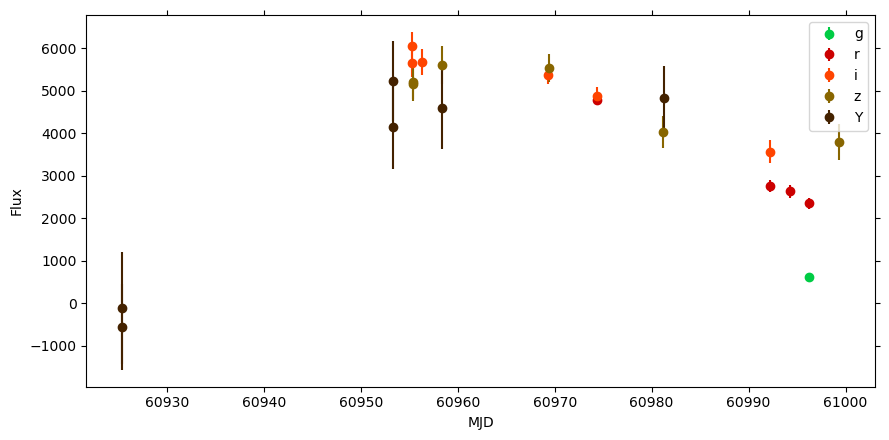

In [7]:
# Plot it:
photometry = hotsne[0]['photometry']
plot_ltcv( photometry['mjd'], photometry['band'], photometry['flux'], photometry['fluxerr'] );

In [43]:
# The API call can package the data in a few different ways.  The default is
#   what's shown above.  If we set the parmaeter return_format to 2, we get
#   something that's better suited for importing into a data frame.
# (It still returns JSON.  Returning a binary serialized data frame is fraught,
#   because those don't always restore well between versions.)

retval = query_tom( "elasticc2/gethottransients", 
                   { "mjd_now": 61000., "detected_in_last_days": 1., "return_format": 2 },
                   verbose=True )

_logger.info( "Making Pandas data frame..." )
hotsne_pandas = pandas.DataFrame( retval['diaobject'] )
_logger.info( "Making Polars data frame..." )
hotsne_polars = polars.DataFrame( retval['diaobject'] )
_logger.info( "...done making dataframes." )

print( f"Pandas dataframe uses {hotsne_pandas.memory_usage(deep=True).sum()/1024/1024:.1f} MiB" )
display( hotsne_pandas[0:5] )

print( f"Polars dataframe uses ~{hotsne_polars.estimated_size('mb'):.1f} MiB" )
display( hotsne_polars[0:5] )

# I'm going to do futher operations on the Polars dataframe.  Although the Polars
#   sytanx is perhaps even more byzantine than Pandas (if you can imagine that),
#   it handles list columsn better than Pandas does.  (For pandas, you probably
#   want to "explode" the dataframe and deal with a multi-level index.)
hotsne = hotsne_polars;

[2024-10-25 13:22:33 - INFO] - Sending elasticc2/gethottransients request to tom...
[2024-10-25 13:23:28 - INFO] - ...done after 54.3 seconds
[2024-10-25 13:23:30 - INFO] - Making Pandas data frame...
[2024-10-25 13:23:30 - INFO] - Making Polars data frame...
[2024-10-25 13:23:32 - INFO] - ...done making dataframes.


Pandas dataframe uses 98.7 MiB


,objectid,ra,dec,mjd,band,flux,fluxerr,zp,redshift,sncode
0,1002611,81.419685,-49.968970,"[60925.3889, 60925.3985, 60953.2899, 60953.312...","[Y, Y, Y, Y, i, i, z, z, i, z, Y, i, z, r, i, ...","[-112.59107, -555.5123, 5231.281, 4139.281, 60...","[1315.0219, 1010.5355, 933.1185, 972.47253, 33...",27.5,-99,-99
1,1002665,76.010132,-30.257800,"[60949.3301, 60949.3539, 60950.3063, 60950.318...","[Y, Y, Y, Y, Y, i, i, z, z, r, i, z, i, i, z, ...","[-825.03766, 62.77219, -1943.0405, -898.07465,...","[1232.0863, 1149.9305, 1047.8407, 1200.26, 135...",27.5,-99,-99
2,1003516,82.045701,-50.100473,"[60925.3926, 60925.4022, 60953.2899, 60953.312...","[Y, Y, Y, Y, i, z, i, z, Y, i, z, i, z, Y, r, ...","[-496.79715, -559.70245, -961.9892, 2602.1426,...","[1153.6647, 911.6201, 937.4305, 984.1008, 322....",27.5,-99,-99
3,1005817,101.808818,-47.275664,"[60954.329, 60954.3516, 60955.3632, 60955.3745...","[Y, Y, z, Y, i, z, i, i, z, r, i]","[-62299.676, -64347.457, 41399.92, 22678.135, ...","[1619.7021, 1574.4094, 1421.069, 1599.6809, 15...",27.5,-99,-99
4,1007129,102.948256,-61.290785,"[60955.3818, 60969.3408, 60969.3527, 60973.351...","[Y, i, z, i, z, Y, z, Y, i, r, i, z]","[1071.8907, 67.256325, 418.2215, -389.7148, -4...","[896.3415, 203.7171, 366.3868, 291.12665, 421....",27.5,-99,-99


Polars dataframe uses ~62.9 MiB


objectid,ra,dec,mjd,band,flux,fluxerr,zp,redshift,sncode
i64,f64,f64,list[f64],list[str],list[f64],list[f64],f64,i64,i64
1002611,81.419685,-49.96897,"[60925.3889, 60925.3985, … 60999.3527]","[""Y"", ""Y"", … ""z""]","[-112.59107, -555.5123, … 3801.1348]","[1315.0219, 1010.5355, … 428.28445]",27.5,-99,-99
1002665,76.010132,-30.2578,"[60949.3301, 60949.3539, … 60999.1766]","[""Y"", ""Y"", … ""g""]","[-825.03766, 62.77219, … 22.669981]","[1232.0863, 1149.9305, … 96.26641]",27.5,-99,-99
1003516,82.045701,-50.100473,"[60925.3926, 60925.4022, … 60999.3527]","[""Y"", ""Y"", … ""z""]","[-496.79715, -559.70245, … 4218.726]","[1153.6647, 911.6201, … 435.79462]",27.5,-99,-99
1005817,101.808818,-47.275664,"[60954.329, 60954.3516, … 60999.2775]","[""Y"", ""Y"", … ""i""]","[-62299.676, -64347.457, … -79094.01]","[1619.7021, 1574.4094, … 1492.498]",27.5,-99,-99
1007129,102.948256,-61.290785,"[60955.3818, 60969.3408, … 60999.3579]","[""Y"", ""i"", … ""z""]","[1071.8907, 67.256325, … -187.3112]","[896.3415, 203.7171, … 538.5722]",27.5,-99,-99


In [9]:
# Let's make a snr column, and then an 'ndets' column with the number of points that have snr >= 5
#
# This requires knowing some Polars syntax, which is nontrivial.

hotsne = hotsne.with_columns( snr = hotsne['flux'] / hotsne['fluxerr'] )
hotsne = hotsne.with_columns( ndets = ( hotsne['snr'].list.eval( polars.element().ge(5) ).list.count_matches(True) ) )

In [10]:
# Just for fun, lets find things with truly lots of detections
manydets = hotsne.filter( hotsne['ndets'] > 100 )

# Pick one at random
which = rng.integers( 0, len(manydets) )
# One particularly annoying thing of Polars... you
#   can't index it with an numpy.int64, so turn
#   "which" into a regular python integer
which = int(which)
manydets[which]

objectid,ra,dec,mjd,band,flux,fluxerr,zp,redshift,sncode,snr,ndets
i64,f64,f64,list[f64],list[str],list[f64],list[f64],f64,i64,i64,list[f64],u32
18597192,8.059171,-43.682868,"[60848.2569, 60848.2574, … 60999.102]","[""g"", ""g"", … ""z""]","[-527.07776, -69.010185, … 1632.5796]","[417.77103, 412.00803, … 376.1189]",27.5,-99,-99,"[-1.261643, -0.167497, … 4.340594]",130


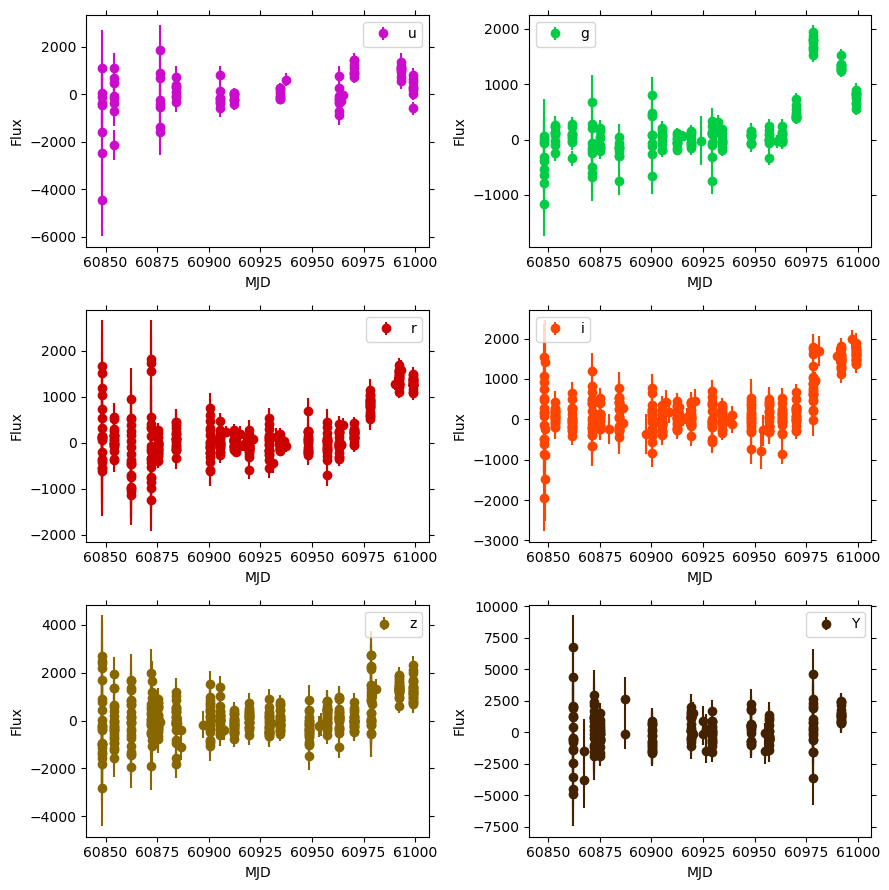

In [11]:
# The version of plot_ltcv in this notebook needs lists, so we have to cast the
#   Polars Serieses we get out to regular python lists
# (The [0] is because we really have polars Series, even though it
#  only has one element.  We want just that element, which itself
#  is a list.)
plot_ltcv( manydets[which]['mjd'][0], manydets[which]['band'][0], manydets[which]['flux'][0], manydets[which]['fluxerr'][0],
           multiplots=True );

# You can see that this is one that was observed a lot, but only started to explode near the end.
# Remember that we gave "mjd_now=61000" to the call above, so any simulated photometry from after
# that date won't be included.

In [20]:
# Some other miscellaneous API endpoints.
#
# The "classids" endpoint will get a dictionary whose keys are broker class IDs.  (Because of
# JSON limitations, these keys are strings, even though ideally they would be ints.)  Each value
# is itself a dictionary; "description" describes the classID, and "gentype" is a list of SNANA
# gentypes that correspond to this classID.  Then there are four booleans that indicate how
# precise the class ID is; from most general to least general, these are generalmatch, broadmatch,
# categorymatch, and exactmatch.  The level of match will correspond to which digits aren't 0
# in the class ID.  For more information, see the ELAsTiCC2 taxonomy at:
#   https://github.com/LSSTDESC/elasticc/blob/elasticc2/taxonomy/taxonomy.ipynb

classidinfo = query_tom( 'elasticc2/classids' )
print( json.dumps( classidinfo, indent=4 ) )


{
    "0": {
        "exactmatch": false,
        "categorymatch": false,
        "broadmatch": false,
        "generalmatch": false,
        "description": "Meta",
        "gentype": []
    },
    "100": {
        "exactmatch": false,
        "categorymatch": false,
        "broadmatch": false,
        "generalmatch": false,
        "description": "Meta/Other",
        "gentype": []
    },
    "200": {
        "exactmatch": false,
        "categorymatch": false,
        "broadmatch": false,
        "generalmatch": false,
        "description": "Residual",
        "gentype": []
    },
    "300": {
        "exactmatch": false,
        "categorymatch": false,
        "broadmatch": false,
        "generalmatch": false,
        "description": "NotClassified",
        "gentype": []
    },
    "1000": {
        "exactmatch": false,
        "categorymatch": false,
        "broadmatch": false,
        "generalmatch": false,
        "description": "Static",
        "gentype": []
    },
    "110

In [21]:
# You can get information about which classifiers provided classifications
# during the ELAsTiCC2 campaign.  The return value is a dictionary, whose
# key is the database's classifier_id.  It's supposed to be an integer, but
# because of limitations in JSON they are actually strings.  Probably run these
# through int() if you actually use them.

res = query_tom( 'elasticc2/classifiers_json' )
print( json.dumps( res, indent=4 ) )


{
    "11": {
        "brokername": "ANTARES",
        "brokerversion": "2.6.8",
        "classifiername": "LightGBM_filter",
        "classifierparams": "v7"
    },
    "12": {
        "brokername": "ALeRCE",
        "brokerversion": "6.0.0",
        "classifiername": "BaltoClassifier",
        "classifierparams": "6.0.0"
    },
    "13": {
        "brokername": "ALeRCE",
        "brokerversion": "1.1.0",
        "classifiername": "TinkyWinkyClassifier",
        "classifierparams": "1.1.0"
    },
    "14": {
        "brokername": "Pitt-Google Broker",
        "brokerversion": "v0.7",
        "classifiername": "SuperNNova_v1.3",
        "classifierparams": ""
    },
    "15": {
        "brokername": "ALeRCE",
        "brokerversion": "3.0.0",
        "classifiername": "MessiClassifier",
        "classifierparams": "3.0.0"
    },
    "16": {
        "brokername": "AMPEL",
        "brokerversion": "v0.8",
        "classifiername": "ElasticcMonsterAllInclPost",
        "classifierparams":

In [64]:
# This one gets you the data you'd need to make your own confusion matrices.
# It's complicated.  This is just one quick example.  For full documentation
# on this endpoint and more instructions for its use, see
#  
#    https://github.com/LSSTDESC/elasticc_metrics/blob/main/elasticc2_rest_metric_demo.ipynb
#
# This one doesn't actually query the database (which would
# take a very long time), but reads cached results of queries
# to the database run previously.
#
#     brokerclassfortruetype/<str:dataformat>/<str:what>/<int:classifier_id>/<int:classid>/
#
# The slash at the end is crucial; otherwise, django gets annoyed.
#
# "dataformat" can be "dict" or "pickle".  If the latter, it gives
# you a pickled Pandas dataframe that may or may not sucessfully
# unpickle with the version of Pandas you're using.  If "dict", you
# get back a dictionary you could feed to 
#    Pandas.DataFrame.from_dict( ..., orient='tight' )
# to get a data frame.  "pickle" will be faster in all ways if it works.
#
# "what" can be one of "objects", "sources", "meanprobabilities", and "maxprobabilities".
#
# "classifier_id" is the numeric classifier id (see previous cell)
#
# "classid" is the ELAsTiCC2 taxonomy of the classid for the *true* class.  These needs
#  to be one of the most specific classes (i.e. the ones digit is not 0).
#
# Example here just gets some basic info about all objects of type SNIa.
# It doesn't actually get any broker classification info.  (See the link
# above for more info.)
#  
#   set dataformat to json
#
#   ask for "objects" just to see what that is
#
#   classifier ID 27 = ALeRCE MessiClasifier v3.1.0
#
#   classid 2222 = SNIa   

res = query_tom( 'elasticc2/brokerclassfortruetype/json/objects/27/2222/', verbose=True )
df = pandas.DataFrame.from_dict( res, orient='tight' )
df

[2024-10-25 14:09:00 - INFO] - Sending elasticc2/brokerclassfortruetype/json/objects/27/2222/ request to tom...
[2024-10-25 14:09:00 - INFO] - ...done after 0.4 seconds


,t.zcmb,t.peakmjd,t.gentype
s.diaobject_id,,,
1000154,0.502343,61504.242,10
1001012,0.308069,61515.680,10
1001852,0.566813,61513.750,10
1004371,0.971284,61526.650,10
1004448,0.599852,61394.780,10
...,...,...,...
159506706,0.610671,61421.773,10
159506951,0.508571,61401.190,10
159507572,0.274884,61552.414,10
